In [1]:
from probatus.feature_elimination import ShapRFECV
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, LeaveOneOut, LeavePOut
from sklearn.model_selection import cross_val_score
import shap
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import settings

In [4]:
comorbidity_data_path = f'{settings.output_folder}icd_10_scaled.csv'
targets_path = f'{settings.raw_data_folder}control/regression_targets.csv'

In [2]:
comorbidity_data = pd.read_csv(comorbidity_data_path)
comorbidity_data = comorbidity_data[comorbidity_data.columns[1:]]
comorbidity_data.head()

,"Endocrine, nutritional and metabolic diseases",Mental and behavioural disorders,Diseases of the nervous system,Diseases of the eye and adnexa and ear and mastoid process,Diseases of the circulatory system,Diseases of the respiratory system,Diseases of the digestive system,Diseases of the skin and subcutaneous tissue,Diseases of the musculoskeletal system and connective tissue,Diseases of the genitourinary system,"Pregnancy, childbirth and the puerperium",Certain conditions originating in the perinatal period,"Congenital malformations, deformations and chromosomal abnormalities","Symptoms, signs and abnormal clinical and laboratory findings, not elsewhere classified",External causes of morbidity and mortality,infectious and parasitic diseases,Neoplasms,Country
0,0.116819,0.003982,0.029111,0.358620,0.317068,0.106863,0.528042,0.099971,0.018798,0.302565,0.212921,0.186310,0.715048,0.498261,0.213145,0.204136,0.056119,Egypt
1,0.007047,0.000175,0.001227,0.004683,0.004962,0.002462,0.002225,0.003033,0.001920,0.007139,0.007311,0.069729,0.046214,0.032297,0.014364,0.005927,0.001819,Libyan Arab Jamahiriya
2,0.020303,0.000613,0.000982,0.000000,0.004010,0.002546,0.004058,0.012974,0.003137,0.002798,0.010916,0.006106,0.009091,0.001477,0.005225,0.003640,0.002076,Mauritius
3,0.000538,0.000065,0.000230,0.014048,0.000221,0.000137,0.000285,0.000948,0.000378,0.000178,0.003025,0.002662,0.004489,0.001181,0.000163,0.000224,0.000217,Mayotte
4,0.025356,0.001458,0.006734,0.037462,0.012426,0.006090,0.013126,0.015431,0.008845,0.019342,0.056512,0.181005,0.071820,0.124645,0.024429,0.018527,0.008840,Morocco


In [3]:
targets = pd.read_csv(targets_path)
print(f'Missing values: {targets.isnull().sum()}')
targets.head()

Missing values: Deaths       0
Confirmed    0
Recovered    0
Country      0
dtype: int64


,Deaths,Confirmed,Recovered,Country
0,0.006186,0.142134,0.123374,Afghanistan
1,0.050951,2.967301,1.792636,Albania
2,0.006558,0.244897,0.167572,Algeria
3,0.001461,0.061687,0.056808,Angola
4,0.108227,4.356147,3.905192,Argentina


In [ ]:
comorbidity_data = comorbidity_data.merge(targets, on='Country', how='inner')

In [ ]:
label_values = ['Deaths', 'Recovered', 'Confirmed']
features_comorbidity = comorbidity_data.columns.drop(label_values)
features_comorbidity = features_comorbidity.drop(['Country'])

In [ ]:
X_comorbidity = comorbidity_data[features_comorbidity]
Y_comorbidity = comorbidity_data[label_values]

In [ ]:
PARAMS = {
    'max_depth': [2, 3, 5, 7],
    'min_child_weight': [3, 4, 5, 6, 7],
    'learning_rate': [0.05, 0.1, 0.25, 0.35],
    'gamma': [0, 0.1],
    'n_estimators': [35, 50, 100, 150, 200, 250, 300],
    'colsample_bytree': [1, 0.9, 0.8, 0.7]
}

In [ ]:
def hyper_parameter_search(X, Y, params):
  xgb = XGBRegressor(n_jobs=-1)
  gscv = GridSearchCV(xgb, params, n_jobs=-1, scoring='neg_mean_absolute_error', cv=5)
  xgboost_best = gscv.fit(X = X, y=Y)
  return xgboost_best.best_params_, xgboost_best.best_score_

In [ ]:
def rfecv_shap_algorithm(estimator, X, Y, algorithm, step=1, score='neg_median_absolute_error'):
  shap_elimination = ShapRFECV(clf=estimator, step=step, cv=10, scoring=score, n_jobs=-1)
  shap_report = shap_elimination.fit_compute(X, Y)
  best_features_rfe_shap = shap_report[shap_report['val_metric_mean'] == shap_report['val_metric_mean'].max()]
  features_shap = list(best_features_rfe_shap['features_set'].values[0])
  features_shap_cv = {}
  features_shap_cv['algorithm'] = 'rfe - measure shap ' + algorithm
  features_shap_cv['selected_features'] = features_shap
  features_shap_cv['number_of_features'] = len(features_shap)
  features_shap_cv['neg_mae_score_cv'] = shap_report['val_metric_mean'].max()
  feat_shap = pd.DataFrame(features_shap_cv)
  feat_shap.to_csv(f'{settings.features_folder}selected_features_rfe_shap_' + algorithm + '.csv', index=False)
  return feat_shap

In [ ]:
xgb_comorbidity_params, xgb_comorbidity_score = hyper_parameter_search(X_comorbidity, Y_comorbidity['Deaths'], PARAMS)

[15:09:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
print(f'best parameters: {xgb_comorbidity_params}')
print(f'score: {xgb_comorbidity_score}')

best parameters: {'colsample_bytree': 0.7, 'gamma': 0, 'learning_rate': 0.25, 'max_depth': 7, 'min_child_weight': 7, 'n_estimators': 200}
score: -0.0358712411404582


In [ ]:
xgb_comorbidity = XGBRegressor(gamma = xgb_comorbidity_params['gamma'],
                               learning_rate = xgb_comorbidity_params['learning_rate'], 
                               max_depth = xgb_comorbidity_params['max_depth'],
                               min_child_weight = xgb_comorbidity_params['min_child_weight'], 
                               n_estimators = xgb_comorbidity_params['n_estimators'], 
                               colsample_bytree = xgb_comorbidity_params['colsample_bytree'],
                               random_state=1)

In [ ]:
rfecv_xgb_comorbidity = rfecv_shap_algorithm(xgb_comorbidity, X_comorbidity, Y_comorbidity['Deaths'], 'comorbidity')

In [ ]:
rfecv_xgb_comorbidity

,algorithm,selected_features,number_of_features,neg_mae_score_cv
0,rfe - measure shap comorbidity,Diseases of the eye and adnexa and ear and mas...,5,-0.034
1,rfe - measure shap comorbidity,Neoplasms,5,-0.034
2,rfe - measure shap comorbidity,Mental and behavioural disorders,5,-0.034
3,rfe - measure shap comorbidity,Diseases of the musculoskeletal system and con...,5,-0.034
4,rfe - measure shap comorbidity,External causes of morbidity and mortality,5,-0.034


In [ ]:
selected_features_comorbidity = rfecv_xgb_comorbidity['selected_features'].values

In [ ]:
X_train_comorbidity, X_test_comorbidity, Y_train_comorbidity, Y_test_comorbidity = train_test_split(
    X_comorbidity[selected_features_comorbidity],
    Y_comorbidity,
    test_size = 0.2,
    random_state = 15
)

In [ ]:
xgb_comorbidity.fit(X_train_comorbidity, Y_train_comorbidity['Deaths'])

[15:09:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0,
             importance_type='gain', learning_rate=0.25, max_delta_step=0,
             max_depth=7, min_child_weight=7, missing=None, n_estimators=200,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=1,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

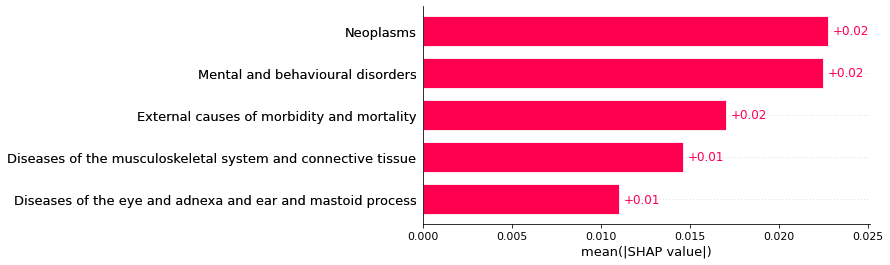

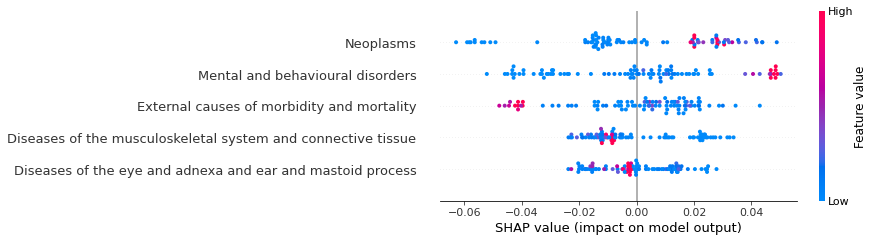

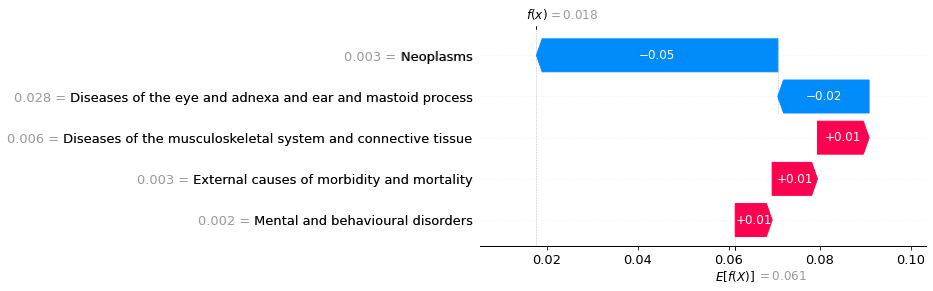

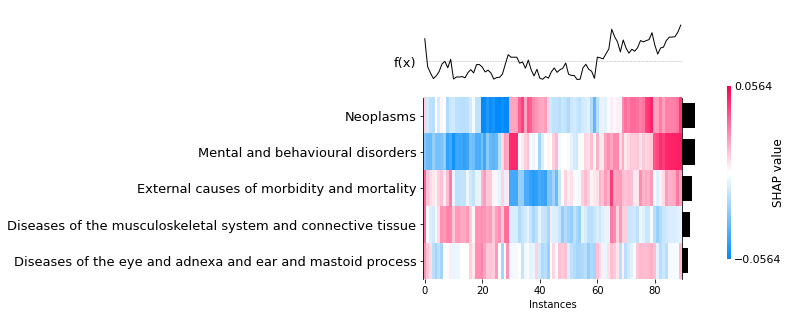

In [ ]:
expl = shap.Explainer(xgb_comorbidity, X_comorbidity[selected_features_comorbidity])
shap_values = expl(X_comorbidity[selected_features_comorbidity])
shap.plots.bar(shap_values)
shap.plots.beeswarm(shap_values)
shap.plots.waterfall(shap_values[30])
shap.plots.heatmap(shap_values)